In [1]:
import collections
import os
import pathlib
import shlex
import subprocess
import re

import h5py
import matplotlib.pyplot as plt
import numpy as np
import psutil
import sklearn.feature_selection
import sklearn.ensemble
import sklearn.impute
import sklearn.linear_model
import sklearn.svm
import rich
import rich.live
import rich.markup
import rich.table
import lib_utils

DATA_PATH = "data/original.shuffled_and_split.h5"

## System preoccupations.
- Print SLURM env vars if we have them.
- Check if we have enough memory.

In [2]:

# We can't always use the SLURM env variables, because they're
# not available if we ssh-ed to the node instead of srun-ing, salloc-ing or sbatch-ing.
# We still print the information if it's available, though.
if "SLURM_JOB_ID" in os.environ:
    table = rich.table.Table("Key", "Value", title="Slurm Environment Variables")
    for key, value in os.environ.items():
        if "slurm" in key.lower():
            table.add_row(key, rich.markup.escape(value))
    rich.print(table)


file_size = os.path.getsize(DATA_PATH) 
dataset_size_str = f"{file_size / 10 ** 9:0.4} GB"
min_memory = file_size + 2 * 10 ** 9

if "SLURM_JOB_ID" in os.environ:
    values = []
    command = [f"scontrol", "show", "job", os.environ["SLURM_JOB_ID"]]
    scontrol = subprocess.check_output(command, 
        universal_newlines=True,
    ).strip().split("\n")

    lines = [line for line in scontrol if "MinMemoryNode=" in line]
    assert len(lines), scontrol
    pat = re.compile(r"MinMemoryNode=(\d+\w)")
    for line in lines:
        line = line.strip()
        matches = filter(lambda x: x, [pat.match(x) for x in line.split(" ")])
        
        for match in matches:
            memory = match.groups()[0]
            parsed = re.match("(\d+)(\D+)", memory)
            if parsed:
                memory = int(parsed.groups()[0])
                unit = parsed.groups()[1].upper()

                if len(unit) == 2 and unit[1] == "B":
                    unit = unit[0]
                
                if unit == "K":
                    memory_parsed = memory * 10 ** 3
                elif unit == "M":
                    memory_parsed = memory * 10 ** 6
                elif unit == "G":
                    memory_parsed = memory * 10 ** 9
                elif unit == "T":
                    memory_parsed = memory * 10 ** 12
                elif unit == "P":
                    memory_parsed = memory * 10 ** 15
                else:
                    raise ValueError(f"Unknown unit: {unit}")
            values.append(dict(method="scontrol", memory_parsed=memory_parsed, memory_raw=f"{memory}{unit}"))

values.append(dict(method="psutil - Not reliable on SLURM", memory_parsed=psutil.virtual_memory().total, memory_raw=None))

table = rich.table.Table("Method", "Memory", "Warning", "Warning Message", title="Memory")
for value in values:    
    table.add_row(
        value["method"], 
        f"{value['memory_parsed'] / 10 ** 9:0.4} GB", 
        "" if value["memory_parsed"] >= min_memory else "❌", 
        f"[red bold]The dataset is {dataset_size_str}. The system doesn't have enough memory to deal with that. [/red bold]" if value["memory_parsed"] < min_memory else ""
    )

rich.print(table)

if any([value["memory_parsed"] < min_memory for value in values]):
    rich.print("[red bold]The dataset is too big for the system to handle. Please, use a system with more memory.[/red bold]")
else:
    rich.print("[green bold]There is enough memory ✅[/green bold]")

    Slurm Environment     
        Variables         
┏━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Key          ┃ Value   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ SLURM_JOB_ID │ 3456257 │
└──────────────┴─────────┘

                                 Memory                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Method                         ┃ Memory   ┃ Warning ┃ Warning Message ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ scontrol                       │ 188.0 GB │         │                 │
│ psutil - Not reliable on SLURM │ 405.4 GB │         │                 │
└────────────────────────────────┴──────────┴─────────┴─────────────────┘

There is enough memory ✅

# Deal with Missing Values
Some features have data missing, represented by float("nan") values in the vector.

We first count how many dimensions of the 450k we have left if we exclude those where more than 10 patients are missing a value for that column.

The original Horvath's clock uses a max of 10 values.

In [3]:
# Load the data. 
# The ; is necessary else the notebook will print out the entire contents of the data object.
data = lib_utils.load_split_data(DATA_PATH)

We plot the number of features kept as a function of maximum NaN values per patient for that feature.

''

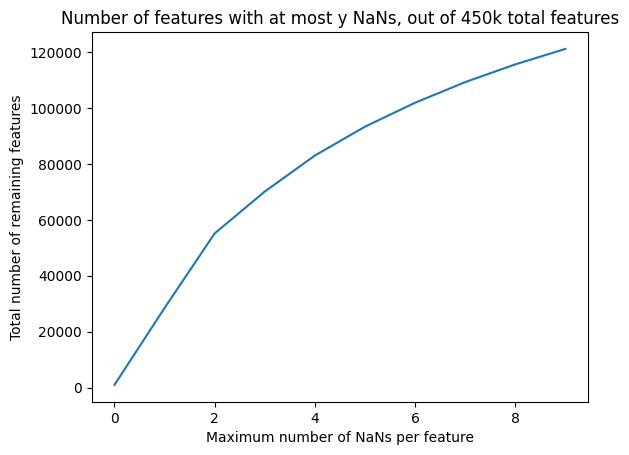

In [4]:
nan_counts_features = np.isnan(data["train"]["features"]).sum(axis=0)

plt.plot([(nan_counts_features <= i).sum() for i in range(10)])
plt.title("Number of features with at most y NaNs, out of 450k total features")
plt.xlabel("Maximum number of NaNs per feature")
plt.ylabel("Total number of remaining features")
;

Out of curiosity, we plot the amount of patients kept as a function of maximum feature missing values.

The top 500 (1/14) patients have more than the 3/4th of their features missing.

''

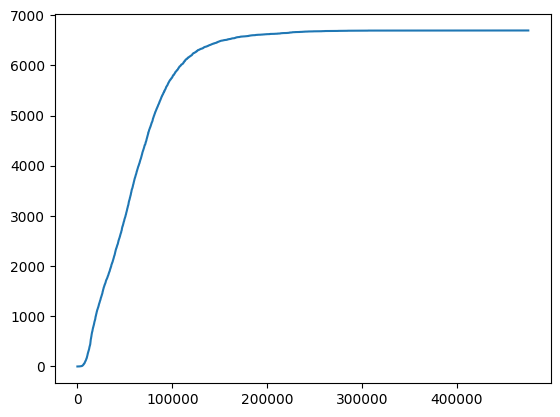

In [5]:
nan_counts_ppl = np.isnan(data["train"]["features"]).sum(axis=1)
plt.plot([(nan_counts_ppl <= i).sum() for i in range(nan_counts_ppl.max())])
;

In [6]:
################################################################# 
# Create a mask of features that have less than 10 missing values,
# and remove them from the dataset, from all columns and splits.
################################################################# 
feature_mask = (np.isnan(data["train"]["features"]).sum(axis=0) < 10)
print(f"Final number of features: {feature_mask.sum()}\n")

subset_data = collections.defaultdict(dict)

table = rich.table.Table("Split", "Information type", "Initial shape", "Final shape")
with rich.live.Live(table, auto_refresh=False) as live:
    for split, split_values in data.items():
        for information_type, information_data in split_values.items():
            initial_shape = information_data.shape
            if information_type == "features":
                subset_data[split][information_type] = information_data[:, feature_mask] 
            else:
                subset_data[split][information_type] = information_data

            table.add_row(split, information_type, f"{initial_shape}", f"{subset_data[split][information_type].shape}")
            live.update(table, refresh=True)

## Imputation
We first try basic imputation, as there are very few missing values, and the amount of features is huge.

In [ ]:
import importlib
lib_utils = importlib.reload(lib_utils)

# Imputation
IMPUTATION_STRATEGY = "mean"
imputer = sklearn.impute.SimpleImputer(strategy=IMPUTATION_STRATEGY)
print(f"Training with imputer {imputer} with strategy {IMPUTATION_STRATEGY}")
imputer.fit(subset_data["train"]["features"])

imputed_subset_data = collections.defaultdict(dict)
with lib_utils.LiveTable("Split", "Information Type", title="Imputating...") as live_table:
    for split, split_values in subset_data.items():
        for information_type, information_data in split_values.items():
            live_table.add_row(**{"Split": split, "Information Type": information_type})
            
            if information_type == "features":
                imputed_subset_data[split][information_type] = imputer.transform(information_data)
            else:
                imputed_subset_data[split][information_type] = information_data
            
print(f"{imputed_subset_data['train']['features'].shape = }")


Training with imputer SimpleImputer() with strategy mean


Output()

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

imputed_subset_data['train']['features'].shape = (6699, 121099)


## Normalization
We normalize the data to mean zero and std 1.

We use numpy's functions that are compatible with NaNs, 
in case if we decide to not imput the data. It just ignores the values.

In [ ]:
# Normalization
mean = np.nanmean(imputed_subset_data["train"]["features"], axis=0, keepdims=True)
std = np.nanstd(imputed_subset_data["train"]["features"], axis=0, keepdims=True)
print(f"{mean.shape = }")
print(f"{std.shape = }")

normalized_imputed_subset_data = collections.defaultdict(dict)
for split, split_values in imputed_subset_data.items():
    for information_type, information_data in split_values.items():
        if information_type == "features":
            normalized_imputed_subset_data[split][information_type] = (information_data - mean) / std
        else:
            normalized_imputed_subset_data[split][information_type] = information_data

del imputed_subset_data
print(f"{normalized_imputed_subset_data['train']['features'].shape = }")

mean.shape = (1, 121099)
std.shape = (1, 121099)
normalized_imputed_subset_data['train']['features'].shape = (6699, 121099)


## Feature Selection
We use the top K features that are the most absolutely correlated with the label.

It would be interesting to prevent the model from learning negative weights, & removing values with negative correlations, & comparing with allowing negative correlations & weights.

In [ ]:
def feature_selection(n_features, normalized_imputed_subset_data):
    
    feature_selector = sklearn.feature_selection.SelectKBest(
        sklearn.feature_selection.f_regression, 
        k=n_features
    ).fit(
        normalized_imputed_subset_data["train"]["features"], 
        normalized_imputed_subset_data["train"]["age"],
    )

    feature_selected_data = collections.defaultdict(dict)
    for split, split_values in normalized_imputed_subset_data.items():
        for information_type, information_data in split_values.items():
            if information_type == "features":
                feature_selected_data[split][information_type] = feature_selector.transform(information_data)
            else:
                feature_selected_data[split][information_type] = information_data
            
    return feature_selected_data

In [ ]:
import importlib
lib_utils = importlib.reload(lib_utils)

def evaluate(*, regressor, feature_selected_data, n_features, live_table, **kwargs):
    preds = regressor.predict(feature_selected_data["validation"]["features"])
    mae = sklearn.metrics.mean_absolute_error(preds, feature_selected_data['validation']['age'])
    mse = sklearn.metrics.mean_squared_error(preds, feature_selected_data['validation']['age'])
    medae = sklearn.metrics.median_absolute_error(preds, feature_selected_data['validation']['age'])

    r2 = regressor.score(
        feature_selected_data['validation']['features'], 
        feature_selected_data['validation']['age'],
    )

    if live_table is not None:
        row_dict = dict(
            r2=r2,
            medae=medae,
            mae=mae,
            mse=mse,
            n_features=n_features,
            **kwargs
        )
        row_dict = {k: str(v) for k, v in row_dict.items()}
        live_table.add_row(**row_dict)
    else:
        print(
            f"### Metrics ### " + 
            f"{r2 = :.2f} # " +  
            f"{medae = :0.2f} # " +
            f"{mae = :.2f} # " +
            f"{mse = :.2f}" + 
            f"\n### HyperParams ### {n_features = } # " +
            " # ".join(f"{k} = {v}" for k, v in kwargs.items())
        )

    return dict(r2=r2, medae=medae, mae=mae, mse=mse)


def train_predict_evaluate(feature_selected_data, n_features, alpha, l1_ratio, live_table, max_iter=10000):
    if alpha == 0:
        regressor = sklearn.linear_model.LinearRegression(
        )
    elif l1_ratio == 0:
        regressor = sklearn.linear_model.Ridge(
            alpha=alpha,
            max_iter=max_iter,
        )
    elif l1_ratio == 1:
        regressor = sklearn.linear_model.Lasso(
            alpha=alpha,
            max_iter=max_iter,
        )
    else:
        regressor = sklearn.linear_model.ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            max_iter=max_iter,
        )

    regressor.fit(
        feature_selected_data["train"]["features"], 
        feature_selected_data["train"]["age"],
    )

    evaluate(
        regressor=regressor,
        feature_selected_data=feature_selected_data,
        n_features=n_features,
        alpha=alpha,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
        live_table=live_table,
    )

    return regressor

def train_histogram_gradient_boosting(feature_selected_data, n_features, learning_rate, max_iter, max_leaf_nodes, live_table=None):
    regressor = sklearn.ensemble.HistGradientBoostingRegressor(
        learning_rate=learning_rate,
        max_iter=max_iter,
        max_leaf_nodes=max_leaf_nodes,
    )

    regressor.fit(
        feature_selected_data["train"]["features"], 
        feature_selected_data["train"]["age"],
    )

    evaluate(
        regressor=regressor,
        feature_selected_data=feature_selected_data,
        n_features=n_features,
        learning_rate=learning_rate,
        max_iter=max_iter,
        max_leaf_nodes=max_leaf_nodes,
        live_table=live_table,
    )

    return regressor


def train_svm(feature_selected_data, n_features, kernel, degree, C, live_table=None):

    regressor = sklearn.svm.SVR(kernel=kernel, degree=degree, C=C)

    regressor.fit(
        feature_selected_data["train"]["features"], 
        feature_selected_data["train"]["age"],
    )
        
    evaluate(
        regressor=regressor,
        feature_selected_data=feature_selected_data,
        n_features=n_features,
        kernel=kernel,
        degree=degree,
        C=C,
        live_table=live_table,
    )

    return regressor



In [ ]:
with lib_utils.LiveTable("r2", "medae", "mae", "mse", "n_features", "alpha", "l1_ratio", "max_iter", title="Big Table") as live_table:
    for n_features_exp in np.linspace(1, 5, 20):
        n_features = int(10 ** n_features_exp)
        feature_selected_data = feature_selection(n_features, normalized_imputed_subset_data)
        for alpha in np.linspace(0, 0.2, 4):
            for l1_ratio in np.linspace(0, 1, (5 if alpha != 0 else 1)):
                estimator = train_predict_evaluate(
                    feature_selected_data=feature_selected_data, 
                    live_table=live_table,
                    alpha=alpha, 
                    l1_ratio=l1_ratio, 
                    n_features=n_features,
                )
                # if hasattr(estimator, "coef_"):
                #     print(f"Sparsity %: {np.isclose(estimator.coef_, 0).mean():0.0%} sparse")
                #     print(f"Sparsity #: {len(estimator.coef_) - np.isclose(estimator.coef_, 0).sum()} / {len(estimator.coef_)}")
                #     print()


Output()

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

Adding row

KeyboardInterrupt: 

In [ ]:
### Metrics ### r2 = 0.90 # medae = 3.85 # mae = 5.37 # mse = 58.08
### HyperParams ### {n_features = } # alpha = 0.2 # l1_ratio = 1.0

# n_features = 112 # alpha = 0.2 # l1_ratio = 1.0
alpha = 0.2
l1_ratio = 1.0
n_features = 112
feature_selected_data = feature_selection(n_features, normalized_imputed_subset_data)
estimator = train_predict_evaluate(
    feature_selected_data=feature_selected_data, 
    alpha=alpha, 
    l1_ratio=l1_ratio, 
    n_features=n_features
)

In [ ]:

alpha = 0.1
l1_ratio = 0.6

for i in np.linspace(1, 6, 20):
    n_features = int(i ** 10)
    feature_selected_data = feature_selection(n_features, normalized_imputed_subset_data)

    for j in np.linspace(1, 3, 10):
        max_leaf_nodes = 1 + int(j ** 10)    
        estimator = train_histogram_gradient_boosting(
            feature_selected_data, n_features, learning_rate=0.1, max_iter=100, max_leaf_nodes=max_leaf_nodes
        )


if hasattr(estimator, "coef_"):
    print(f"Sparsity %: {np.isclose(estimator.coef_, 0).mean():0.0%} sparse")
    print(f"Sparsity #: {len(estimator.coef_) - np.isclose(estimator.coef_, 0).sum()} / {len(estimator.coef_)}")



In [ ]:
print(f"Sparsity %: {np.isclose(estimator.coef_, 0).mean():0.0%} sparse")
print(f"Sparsity #: {len(estimator.coef_) - np.isclose(estimator.coef_, 0).sum()} / {len(estimator.coef_)}")

In [ ]:
np.arange(1 - np.isclose(estimator.coef_, 0))

In [ ]:
len(estimator.coef_) * (1 - .71)